In [1]:
# The script is used to integrate data between human PFC and macaque PFC data
suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(SeuratDisk))
suppressMessages(library(harmony))
library(hdf5r)
options(future.globals.maxSize=100*1024^3) # 100G memory




Attaching package: ‘hdf5r’


The following object is masked from ‘package:purrr’:

    flatten_df




In [2]:
metaTb = read_csv("/home/liuzhen/project/monkeyBrain/data/snRNAseq/snRNA.266clusters.metainfo.csv")



Rows: 1335648 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): CellID, library, brain_area, source, Class, SubClass, Cluster

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
library(readxl)

In [3]:
unique(metaTb$source)

[1] "Macaca_V1" "Macaca_V2"

In [4]:
metaTb_maca2=metaTb[metaTb$source=='Macaca_V2',]

In [63]:
ref1=read_xlsx('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/LYX_Cortex_libid.xlsx')
colnames(ref1)=c('macaque','macaque_id','macaque_id_area','libID','brain','area')

ref2=read_xlsx('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/LYX_Cortex_libid.xlsx',sheet = 'Sheet2')
colnames(ref2)
ref2=rbind(ref2,colnames(ref2))
colnames(ref2)=c('area1','area2','area3','area4','area5','area')

ref2[ref2$area4=='V1',]$area='V1'
ref2[ref2$area4=='F1',]$area='F1'

ref1=left_join(ref1,ref2)
ref1_sort=ref1[,c('macaque_id','libID','area4')]


New names:
• `` -> `...5`
• `` -> `...6`


[1] "occipital"                            
[2] "Ocx"                                  
[3] "visual area 1 (primary visual cortex)"
[4] "V1"                                   
[5] "...5"                                 
[6] "...6"

Joining, by = "area"


In [72]:
ref3=read_xlsx('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/LYX_Cortex_libid_renew.xlsx')
colnames(ref3)=c('macaque','macaque_id','a','libID','brain','area1','area4')

ref3=ref3[c(54:59),]
ref3_sort=ref3[,c('macaque_id','libID','area4')]

ref3_sort=left_join(ref3_sort,metaTb_libsum)
#ref3_sort=ref3_sort[!is.na(ref3_sort$lib_num),]

ref3_sort
ref3_sort %>% group_by(area4) %>% summarise(area_sum=sum(lib_num))




New names:
• `` -> `...7`
Joining, by = "libID"


macaque_id,libID,area4,lib_num
<chr>,<chr>,<chr>,<dbl>
MQC286,6451-1-220822,7A,3287
MQC286,6451-2-220822,7A,2982
MQC286,6457-1-220822,7A,4415
MQC286,6457-2-220822,7A,4721
MQC286,6456-1-220822,7B,3806
MQC286,6456-2-220822,7B,3264


area4,area_sum
<chr>,<dbl>
7A,15405
7B,7070


In [55]:
metaTb$num=1
metaTb_libsum=metaTb %>% group_by(library) %>% summarise(lib_num=sum(num))
colnames(metaTb_libsum)=c('libID','lib_num')


In [56]:
ref1_sort=left_join(ref1_sort,metaTb_libsum)
ref1_sort=ref1_sort[!is.na(ref1_sort$lib_num),]

ref1_sort

Joining, by = "libID"


macaque_id,libID,area4,lib_num
<chr>,<chr>,<chr>,<dbl>
MQC286,6087-2-220804,10,1913
Mq179,116T143-1-210422,10,3398
MQC286,6088-1-220804,10,5172
MQC286,6088-2-220804,10,4570
Mq179,117T143-2-210422,10,3577
MQC286,6089-1-220804,10,4904
MQC286,6089-2-220804,10,4784
MQC286,6118-1-220808,24,568
MQC286,6118-2-220808,24,854


In [57]:
ref1_sort_286=ref1_sort[ref1_sort$macaque_id=='MQC286',]
ref1_sort_179=ref1_sort[ref1_sort$macaque_id=='Mq179',]
ref1_sort_all=ref1_sort


In [58]:
ref1_sort_286 %>% group_by(area4) %>% summarise(area_sum=sum(lib_num))
ref1_sort_179 %>% group_by(area4) %>% summarise(area_sum=sum(lib_num))
ref1_sort_all %>% group_by(area4) %>% summarise(area_sum=sum(lib_num))



area4,area_sum
<chr>,<dbl>
10,21343
24,36508
F1,4610
TE,35843
V1,26519


area4,area_sum
<chr>,<dbl>
10,6975
F1,10784
V1,31986


area4,area_sum
<chr>,<dbl>
10,28318
24,36508
F1,15394
TE,35843
V1,58505


In [77]:
ref3_sort

macaque_id,libID,area4,lib_num
<chr>,<chr>,<chr>,<dbl>
MQC286,6451-1-220822,7A,3287
MQC286,6451-2-220822,7A,2982
MQC286,6457-1-220822,7A,4415
MQC286,6457-2-220822,7A,4721
MQC286,6456-1-220822,7B,3806
MQC286,6456-2-220822,7B,3264


In [80]:
group_id_10=ref1_sort_all[ref1_sort_all$area4=='10' &
                          ref1_sort_all$macaque_id=='MQC286',]$libID
group_id_24=ref1_sort_all[ref1_sort_all$area4=='24' &
                          ref1_sort_all$macaque_id=='MQC286',]$libID
group_id_F1=ref1_sort_all[ref1_sort_all$area4=='F1' ,]$libID
group_id_V1=ref1_sort_all[ref1_sort_all$area4=='V1' &
                          ref1_sort_all$macaque_id=='MQC286',]$libID
group_id_TE=ref1_sort_all[ref1_sort_all$area4=='TE' &
                          ref1_sort_all$macaque_id=='MQC286',]$libID
group_id_7A=ref3_sort[ref3_sort$area4=='7A' &
                          ref3_sort$macaque_id=='MQC286',]$libID





In [81]:
group_id_10_meta=metaTb[metaTb$library %in% group_id_10,]
group_id_24_meta=metaTb[metaTb$library %in% group_id_24,]
group_id_F1_meta=metaTb[metaTb$library %in% group_id_F1,]
group_id_V1_meta=metaTb[metaTb$library %in% group_id_V1,]
group_id_TE_meta=metaTb[metaTb$library %in% group_id_TE,]
group_id_7A_meta=metaTb[metaTb$library %in% group_id_7A,]


In [83]:

nrow(group_id_10_meta)
nrow(group_id_24_meta)
nrow(group_id_F1_meta)
nrow(group_id_V1_meta)
nrow(group_id_TE_meta)
nrow(group_id_7A_meta)


[1] 21343

[1] 36508

[1] 15394

[1] 26519

[1] 35843

[1] 15405

In [89]:
head(group_id_10_meta)

CellID,library,brain_area,source,Class,SubClass,Cluster,num
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CELL279_N3_6087-2-220804,6087-2-220804,10mc,Macaca_V2,ASC,ASC,ASC-16,1
CELL1714_N1_6087-2-220804,6087-2-220804,10mc,Macaca_V2,ASC,ASC,ASC-16,1
CELL5217_N1_6088-1-220804,6088-1-220804,10mr,Macaca_V2,ASC,ASC,ASC-16,1
CELL3105_N1_6088-1-220804,6088-1-220804,10mr,Macaca_V2,ASC,ASC,ASC-16,1
CELL4601_N1_6088-1-220804,6088-1-220804,10mr,Macaca_V2,ASC,ASC,ASC-16,1
CELL2261_N1_6088-1-220804,6088-1-220804,10mr,Macaca_V2,ASC,ASC,ASC-16,1


In [95]:
df=as.data.frame(table(group_id_10_meta$Cluster))
sel_n=df[df$Freq>50,]$Var1
group_id_10_meta=group_id_10_meta[group_id_10_meta$Cluster %in% sel_n,]
length(unique(group_id_10_meta$Cluster))
nrow(group_id_10_meta)

all_n=unique(group_id_10_meta$Cluster)
setdiff(all_n,c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)]))

df=as.data.frame(table(group_id_24_meta$Cluster))
sel_n=df[df$Freq>50,]$Var1
group_id_24_meta=group_id_24_meta[group_id_24_meta$Cluster %in% sel_n,]
length(unique(group_id_24_meta$Cluster))
nrow(group_id_24_meta)
all_n=unique(group_id_24_meta$Cluster)
setdiff(all_n,c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)]))

df=as.data.frame(table(group_id_F1_meta$Cluster))
sel_n=df[df$Freq>50,]$Var1
group_id_F1_meta=group_id_F1_meta[group_id_F1_meta$Cluster %in% sel_n,]
length(unique(group_id_F1_meta$Cluster))
nrow(group_id_F1_meta)
all_n=unique(group_id_F1_meta$Cluster)
setdiff(all_n,c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)]))

df=as.data.frame(table(group_id_V1_meta$Cluster))
sel_n=df[df$Freq>50,]$Var1
group_id_V1_meta=group_id_V1_meta[group_id_V1_meta$Cluster %in% sel_n,]
length(unique(group_id_V1_meta$Cluster))
nrow(group_id_V1_meta)
all_n=unique(group_id_V1_meta$Cluster)
setdiff(all_n,c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)]))



df=as.data.frame(table(group_id_TE_meta$Cluster))
sel_n=df[df$Freq>50,]$Var1
group_id_TE_meta=group_id_TE_meta[group_id_TE_meta$Cluster %in% sel_n,]
length(unique(group_id_TE_meta$Cluster))
nrow(group_id_TE_meta)
all_n=unique(group_id_TE_meta$Cluster)
setdiff(all_n,c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)]))



df=as.data.frame(table(group_id_7A_meta$Cluster))
sel_n=df[df$Freq>50,]$Var1
group_id_7A_meta=group_id_7A_meta[group_id_7A_meta$Cluster %in% sel_n,]
length(unique(group_id_7A_meta$Cluster))
nrow(group_id_7A_meta)
all_n=unique(group_id_7A_meta$Cluster)
setdiff(all_n,c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)]))







[1] 104

[1] 18889

[1] "ASC-4"  "ASC-11" "OPC-0"

[1] 142

[1] 34310

[1] "ASC-4"  "ASC-5"  "ASC-11" "ASC-23" "OLG-10" "OLG-13" "OPC-0"

[1] 75

[1] 12060

[1] "ASC-20" "ASC-2"  "ASC-3"  "ASC-5"  "ASC-7"  "ASC-26" "EC-22"  "MG-15" 
 [9] "OLG-6"  "OLG-10" "OLG-13" "OLG-19" "OLG-25" "OLG-29" "OLG-30" "OPC-0"

[1] 67

[1] 24395

[1] "ASC-16" "ASC-34" "ASC-2"  "ASC-7"  "ASC-26" "ASC-11" "ASC-32" "OLG-6" 
 [9] "OLG-10" "OLG-13" "OLG-25" "OPC-0"

[1] 145

[1] 33547

[1] "ASC-5"  "ASC-7"  "ASC-11" "OPC-0"

[1] 73

[1] 12257

character(0)

In [97]:
df=as.data.frame(table(group_id_10_meta$Cluster))
all_n=unique(group_id_10_meta$Cluster)
sel=c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)])
group_id_10_meta=group_id_10_meta[group_id_10_meta$Cluster %in% sel,]
nrow(group_id_10_meta)

df=as.data.frame(table(group_id_24_meta$Cluster))
all_n=unique(group_id_24_meta$Cluster)
sel=c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)])
group_id_24_meta=group_id_24_meta[group_id_24_meta$Cluster %in% sel,]
nrow(group_id_24_meta)

df=as.data.frame(table(group_id_F1_meta$Cluster))
all_n=unique(group_id_F1_meta$Cluster)
sel=c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)])
group_id_F1_meta=group_id_F1_meta[group_id_F1_meta$Cluster %in% sel,]
nrow(group_id_F1_meta)

df=as.data.frame(table(group_id_V1_meta$Cluster))
all_n=unique(group_id_V1_meta$Cluster)
sel=c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)])
group_id_V1_meta=group_id_V1_meta[group_id_V1_meta$Cluster %in% sel,]
nrow(group_id_V1_meta)

df=as.data.frame(table(group_id_TE_meta$Cluster))
all_n=unique(group_id_TE_meta$Cluster)
sel=c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)])
group_id_TE_meta=group_id_TE_meta[group_id_TE_meta$Cluster %in% sel,]
nrow(group_id_TE_meta)

df=as.data.frame(table(group_id_7A_meta$Cluster))
all_n=unique(group_id_7A_meta$Cluster)
sel=c(all_n[grep('EX',all_n)],all_n[grep('IN',all_n)])
group_id_7A_meta=group_id_7A_meta[group_id_7A_meta$Cluster %in% sel,]
nrow(group_id_7A_meta)

[1] 18709

[1] 33406

[1] 9112

[1] 23009

[1] 33136

[1] 12257

In [98]:
outdir='/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/'
write.csv(group_id_10_meta,paste0(outdir,'cortex_10.csv'))
write.csv(group_id_24_meta,paste0(outdir,'cortex_24.csv'))
write.csv(group_id_F1_meta,paste0(outdir,'cortex_F1.csv'))
write.csv(group_id_V1_meta,paste0(outdir,'cortex_V1.csv'))
write.csv(group_id_TE_meta,paste0(outdir,'cortex_TE.csv'))
write.csv(group_id_7A_meta,paste0(outdir,'cortex_7A.csv'))



In [100]:
loom.file = Connect(filename = paste0("/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/macaque_cortex_F1.loom"), mode="r")
loom.file[["matrix"]]
macaqueSeurat = as.Seurat(loom.file)
loom.file$close_all()
macaqueSeurat
#saveRDS(macaqueSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/cortex_F1.rds')



Class: H5D
Dataset: /matrix
Filename: /home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/macaque_cortex_F1.loom
Access type: H5F_ACC_RDONLY
Datatype: H5T_IEEE_F32LE
Space: Type=Simple     Dims=9112 x 21970     Maxdims=Inf x 21970
Chunk: 64 x 64

Reading in /matrix

Storing /matrix as counts

Saving /matrix to assay 'RNA'



An object of class Seurat 
21970 features across 9112 samples within 1 assay 
Active assay: RNA (21970 features, 0 variable features)

In [102]:
seurat=macaqueSeurat

seurat = SCTransform(
    seurat, assay="RNA",
    ncells=ncol(seurat[["RNA"]]), 
    variable.features.n=3000,
    return.only.var.genes = F,
    method = "glmGamPoi"
) %>%
    RunPCA(verbose = FALSE) %>%
    FindNeighbors(dims = 1:30) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:30)
return(seurat)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18463 by 9112

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 9112 cells



  |======================================================================| 100%


Second step: Get residuals using fitted parameters for 18463 genes



  |======================================================================| 100%


Computing corrected count matrix for 18463 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.500502 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:49:04 UMAP embedding parameters a = 0.9922 b = 1.112

15:49:04 Read 9112 rows and found 30 numeric columns

15:49:04 Using Annoy for neighbor search, n_neighbors = 30

15:49:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:49:05 Wr

An object of class Seurat 
40433 features across 9112 samples within 2 assays 
Active assay: SCT (18463 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.SCT.harmony; see ?make.names for more details on syntax validity”
Computing nearest neighbor graph

Computing SNN

15:57:20 UMAP embedding parameters a = 0.9922 b = 1.112

15:57:20 Read 9112 rows and found 50 numeric columns

15:57:20 Using Annoy for neighbor search, n_neighbors = 30

15:57:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:57:21 Writing NN index file to temp file /tmp/RtmpxxIWX9/file9b6229aabd97

15:57:21 Searching Annoy index using 1 thread, search_k = 3000

15:57:23 Annoy recall = 100%

15:57:24 Commencing smo

An object of class Seurat 
40433 features across 9112 samples within 2 assays 
Active assay: SCT (18463 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

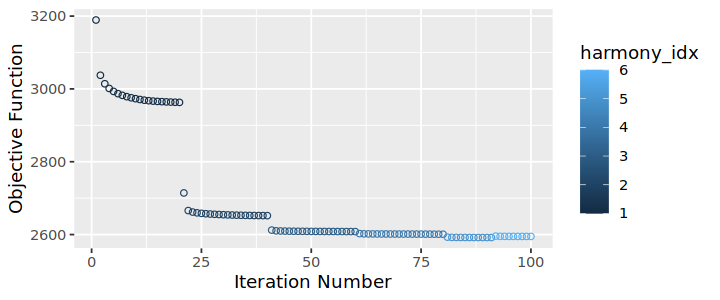

In [110]:
# Run harmony
DefaultAssay(seurat) = "SCT"
options(repr.plot.width=6, repr.plot.height=2.5)
seurat = RunHarmony(
seurat, group.by.vars="source", plot_convergence=T,
assay.use="SCT", reduction = "pca", dims.use=1:50
)
seurat = seurat %>%
FindNeighbors(reduction="harmony", dims = 1:50) %>%
FindClusters(verbose = FALSE) %>%
RunUMAP(reduction="harmony", dims = 1:50)
return(seurat)


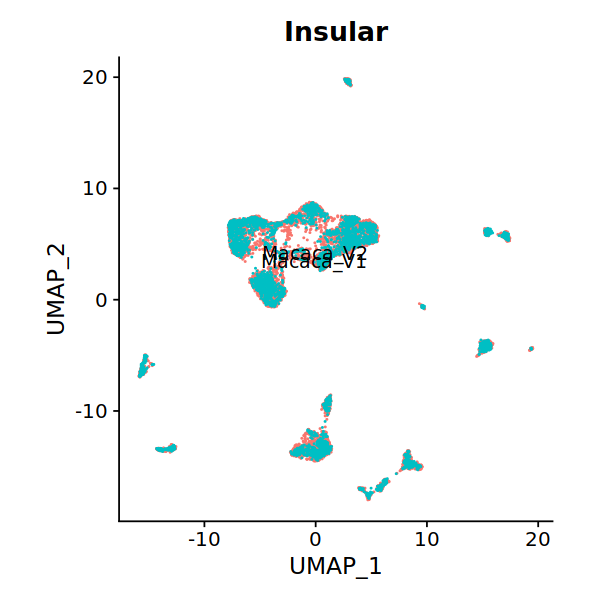

In [112]:
options(repr.plot.width=5, repr.plot.height=5)

DimPlot(seurat, reduction="umap", group.by="source",label=T)+coord_fixed()+NoLegend()+ggtitle("Insular")

        


In [108]:
unique(seurat@meta.data$source)

[1] "Macaca_V1" "Macaca_V2"

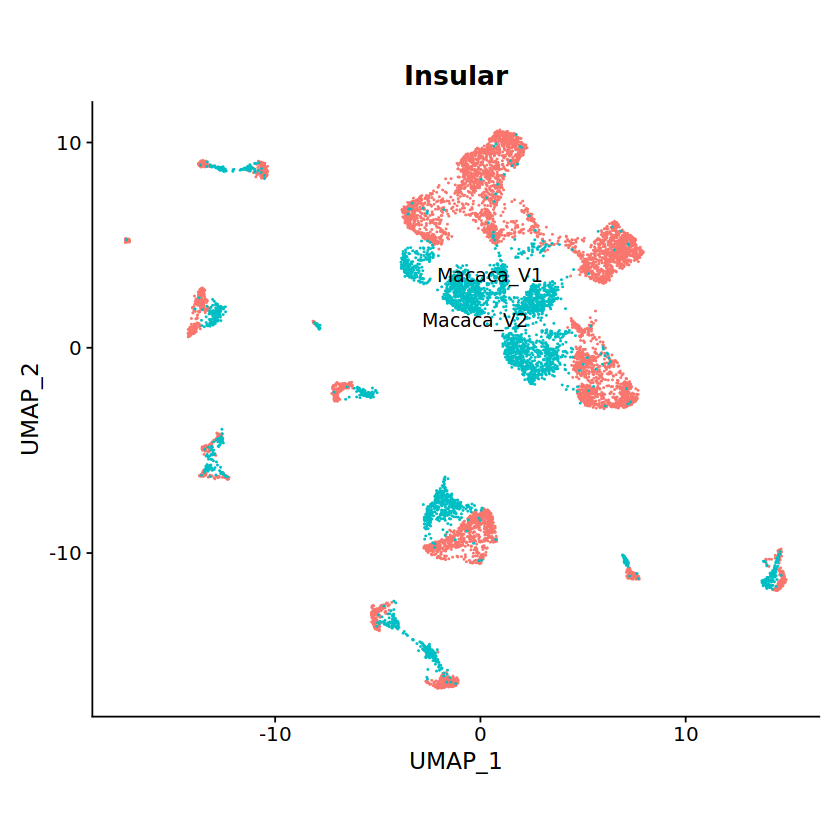

In [109]:
DimPlot(seurat, reduction="umap", group.by="source",label=T)+coord_fixed()+NoLegend()+ggtitle("Insular")

        


In [113]:
saveRDS(macaqueSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/cortex_F1.rds')


In [115]:
loom.file = Connect(filename = paste0("/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/macaque_cortex_V1.loom"), mode="r")
loom.file[["matrix"]]
macaqueSeurat = as.Seurat(loom.file)
loom.file$close_all()
macaqueSeurat
saveRDS(macaqueSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/cortex_V1.rds')


Class: H5D
Dataset: /matrix
Filename: /home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/macaque_cortex_V1.loom
Access type: H5F_ACC_RDONLY
Datatype: H5T_IEEE_F32LE
Space: Type=Simple     Dims=23009 x 21970     Maxdims=Inf x 21970
Chunk: 64 x 64

Reading in /matrix

Storing /matrix as counts

Saving /matrix to assay 'RNA'



An object of class Seurat 
21970 features across 23009 samples within 1 assay 
Active assay: RNA (21970 features, 0 variable features)

In [118]:
for(i in c('10','24','7A','TE')){
    loom.file = Connect(filename = paste0("/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/macaque_cortex_",i,".loom"), mode="r")
    loom.file[["matrix"]]
    macaqueSeurat = as.Seurat(loom.file)
    loom.file$close_all()
    macaqueSeurat
    saveRDS(macaqueSeurat,paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/1012_compare_to_cortex/data/cortex_',i,'.rds'))

}

Reading in /matrix

Storing /matrix as counts

Saving /matrix to assay 'RNA'

Reading in /matrix

Storing /matrix as counts

Saving /matrix to assay 'RNA'

Reading in /matrix

Storing /matrix as counts

Saving /matrix to assay 'RNA'

Reading in /matrix

Storing /matrix as counts

Saving /matrix to assay 'RNA'

